<a href="https://colab.research.google.com/github/IntroComputationalPhysics-UNT/connecting-to-github-classroom-nworbehc/blob/main/PeriodAndRevolutionTime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PSEUDOCODE FOR REVOLUTION TIME**
1. Import necessary modules
    - numpy, matplotlib.pyplot, solve_ivp from scipy.integrate, quad from scipy.integrate
2. Define the ODE, define the integrand
    - ode_func(statevar, t, omega_0), name it something fun
    - period_integrand(args)
    - revtime_integrand(args)
3. Define utility functions for plotting etc
    - plot function
4. Define event functions
    - event for period: find where angular velocity is 0
5. Solve for period $T$ and revolution time $T_r$ using the event functions and ODE
6. Solve using the integrals
7. Plot the results together, compare the methods

In [116]:
#STEP 1: Imported goods

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, quad

In [127]:
#STEP 2: Define the functions

#Rigid Pendulum ODE
def Rigid_Pendulum_ODE(t, y, omega_0=1): #defining the ode function
  """
  Takes in state variable and natural frequency,
  returns angular velocity and angular acceleration
  """
  theta, ang_vel = y  #unpacking the state variable
  ang_accel = -omega_0**2 * np.sin(theta)
  dy_dt = [ang_vel, ang_accel]
  return dy_dt

#Integrands
def Period_Integrand(theta, theta_0, omega_0=1):
  """
  Returns the integrand for period time that we found in
  class. Takes in angle, initial angle, and natural
  frequency.
  """
  coeff = 1/(np.sqrt(2)*omega_0)
  denominator = np.sqrt( np.cos(theta) - np.cos(theta_0) ) # denominator of integrand
  return coeff/denominator

def Revolution_Integrand(theta, ang_vel_0, omega_0=1):
  """
  Returns the integrand for revolution time that we
  found in class, takes in angle, intial angular velocity,
  and natural frequency. Assumes that initial energy is
  entirely kinetic, ie pendulum starts hanging straight down
  """
  coeff = 1/(np.sqrt(2)*omega_0)
  denominator = np.sqrt(np.cos(theta) - 1 + (ang_vel_0**2)/(2*(omega_0**2))) #integrand we found in class
  return coeff/denominator

In [128]:
#STEP 3: Utilities

#Plotting function
def Mr_Plot(x, y1, y2, xlabel=None, ylabel=None, xtitle=None, ytitle=None, title=None, figsize=(6,6)):
  """
  Takes in x and y values to plot, names for the axes,
  and sets the size for the graph.
  """
  plt.figure(figsize=figsize)
  plt.plot(x, y1, 'o-', label=xlabel)
  plt.plot(x, y2, 's-', label=ylabel)
  plt.xlabel(xtitle)
  plt.ylabel(ytitle)
  plt.title(title)
  plt.legend()
  plt.grid(True)
  return plt.show()


In [129]:
#STEP 4: Event functions

#Period event function
def T_Event(t, y, omega_0=1):
  """
  This event function is for the turning points for
  angular velocity. Useful for the case where our initial
  angular velocity isn't enough to cause the pendulum to
  spin around
  """
  theta, ang_vel = y
  return ang_vel
T_Event.terminal = False
T_Event.direction = -1   #2nd derivative test: only find zeros going from pos to neg

#Revolution event function

def T_Rev_Event(t, y, theta_0):
    """
    This event function finds every time the pendulum makes
    one full revolution, ie when theta gets 2pi larger than
    theta_0. Needed for case where pendulum is spinning round
    """
    theta, ang_vel = y
    return theta - (theta_0 + 2*np.pi)
T_Rev_Event.terminal = False
T_Rev_Event.direction = 1

In [140]:
def Extract_T(n_points, eps=1e-3, omega_0=1):
  """
  Extracting the period using the solve_ivp method and with quad integration
  """
  theta_0_list = np.linspace(eps, np.pi - eps, n_points) # list of initial angles (mesh)
  period_list_ode = [] # initialize list of periods
  period_list_int = []

  t_min = 0
  t_max = 100
  t_span = [t_min, t_max] # time span for solve_ivp

  for theta_0 in theta_0_list:
    y_0 = [theta_0, 0] # define state var, initial condition

    #solve_ivp
    sol = solve_ivp(Rigid_Pendulum_ODE, t_span, y_0, args=(omega_0,),
                max_step = 0.1,
                dense_output=False,
                events=T_Event)

    period = np.mean(np.diff(sol.t_events))
    period_list_ode.append(period)

    #quad
    T_int, _ = quad(Period_Integrand, 0, theta_0, args=(theta_0, omega_0))
    period_list_int.append(4.0 * T_int)  # multiply by 4 for full period

  period_list_ode = np.array(period_list_ode) # convert to a numpy array

  period_list_ode = np.concatenate([period_list_ode[::-1], period_list_ode]) # enforcing symmetry to extend data
  theta_0_list = np.concatenate([-theta_0_list[::-1], theta_0_list]) # enforcing symmetry to extend data
  period_list_int = np.concatenate([period_list_int[::-1], period_list_int])
  return theta_0_list, period_list_ode, period_list_int

def Extract_Rev(n_points, theta_0=0, omega_0=1):
    """
    Extract revolution times of a spinning pendulum using ODE and integral.
    """
    ang_vel_list = np.linspace(2*omega_0, 10, n_points)
    rev_ode = []
    rev_integral = []
    t_span = [0, 100]

    for w0 in ang_vel_list:
        y0 = [theta_0, w0]
        sol = solve_ivp(
            Rigid_Pendulum_ODE,
            t_span,
            y0,
            args=(theta_0,),
            max_step=0.1,
            events=T_Rev_Event)

        if len(sol.t_events[0]) > 0:
            rev_ode.append(sol.t_events[0][0])
        else:
            rev_ode.append(np.nan)

        T_int, _ = quad(Revolution_Integrand, 0, 2*np.pi, args=(w0, omega_0))
        rev_integral.append(T_int)

    return ang_vel_list, rev_ode, rev_integral

/tmp/ipython-input-4127361163.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  return coeff/denominator


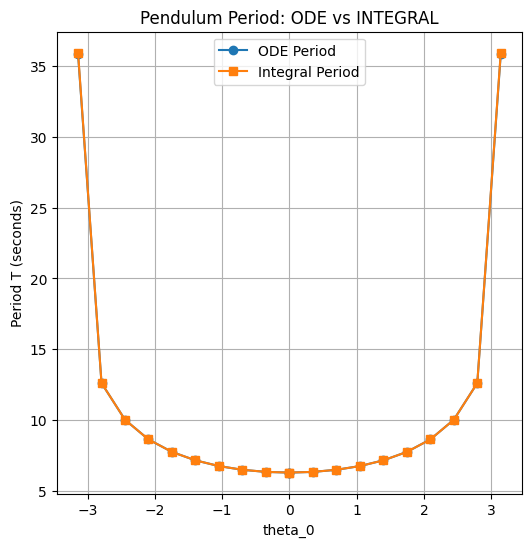

List of period ode values: [35.84753036 12.6049518  10.01534713  8.62502784  7.74209588  7.14723193
  6.74331416  6.48042618  6.3315877   6.2831857   6.2831857   6.3315877
  6.48042618  6.74331416  7.14723193  7.74209588  8.62502784 10.01534713
 12.6049518  35.84753036]
List of period integral values: [35.94878944 12.60495489 10.0153481   8.62502831  7.74209613  7.14723208
  6.74331425  6.48042623  6.33158771  6.28318568  6.28318568  6.33158771
  6.48042623  6.74331425  7.14723208  7.74209613  8.62502831 10.0153481
 12.60495489 35.94878944]


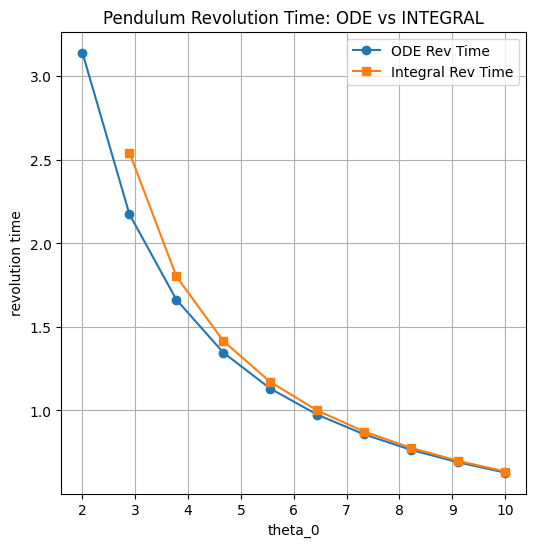

List of revolution time ode values: [np.float64(3.1415926535897936), np.float64(2.17494876017755), np.float64(1.663196110724008), np.float64(1.3463968515384832), np.float64(1.1309733552923256), np.float64(0.9749770304244185), np.float64(0.85679799643358), np.float64(0.7641711860083281), np.float64(0.6896178995684912), np.float64(0.6283185307179584)]
List of revolution time integral values: [inf, 2.5434214783084386, 1.8026798063097025, 1.415558132847004, 1.170555290943764, 0.9998167132071937, 0.8734332929479527, 0.7758670585288285, 0.6981583046523527, 0.6347471389816663]


In [141]:
#STEP 6: Mr Plot! Mr Plot! That name again is Mr Plot!

n_points = 10
theta_0_list, period_ode, period_integral= Extract_T(n_points)
ang_vel_list, rev_ode, rev_integral = Extract_Rev(n_points)

#plot for period
Mr_Plot(theta_0_list, period_ode, period_integral, xlabel='ODE Period', ylabel='Integral Period',
        xtitle='theta_0',ytitle='Period T (seconds)',title="Pendulum Period: ODE vs INTEGRAL")
print("List of period ode values:",period_ode)
print("List of period integral values:", period_integral)

#plot for revolution time
Mr_Plot(ang_vel_list, rev_ode, rev_integral, xlabel='ODE Rev Time', ylabel='Integral Rev Time',
        xtitle='theta_0',ytitle='revolution time',title='Pendulum Revolution Time: ODE vs INTEGRAL')
print("List of revolution time ode values:",rev_ode)
print("List of revolution time integral values:", rev_integral)

In [ ]:
#CODE TO SAVE - IGNORE THIS
# def Extract_Rev(n_points, ang_vel_0=4, eps=1e-3, omega_0=1):
    # """
    # Extract revolution times of a spinning pendulum using ODE and integral.
    # """
    # theta_0_list = np.linspace(eps, np.pi - eps, n_points)
    # rev_list_ode = []
    # rev_list_int = []

    # t_span = [0, 100]  # time span for ODE

    # for theta_0 in theta_0_list:
    #     y_0 = [theta_0, ang_vel_0]

    #     #solve_ivp
    #     sol = solve_ivp(Rigid_Pendulum_ODE, t_span, y_0, args=(theta_0,),
    #         max_step=0.01, dense_output=False, events=T_Rev_Event)

    #     if len(sol.t_events[0]) > 0:
    #         rev_time = sol.t_events[0][0]
    #     else:
    #         rev_time = np.nan  # no revolution detected
    #     rev_list_ode.append(rev_time)

    #     #quad
    #     T_int, _ = quad(Revolution_Integrand, 0, 2*np.pi, args=(ang_vel_0, omega_0))
    #     rev_list_int.append(T_int)

    # return theta_0_list, rev_list_ode, rev_list_int